# Simple implementation of SSD Single Shot MultiBox Detector

Paper SSD: Single Shot MultiBox Detector [https://arxiv.org/pdf/1512.02325.pdf]
Inspiration from https://github.com/rykov8/ssd_keras



# Datasets


French Traffic lights (jpeg zipped, 468MB  | ground truth txt, 0.5MB) 
Sometimes, only one traffic light is marked among multiple ones and the labels are incorrect.
http://www.lara.prd.fr/benchmarks/trafficlightsrecognition
    

**To try:**

German traffic lights 5093 images, 10756 annotated traffic lights
https://hci.iwr.uni-heidelberg.de/node/6132

VIVA traffic light detection benchmark (California) Day Train Set (12.4 GB,Day Test Set 3.8 GB)
http://cvrr.ucsd.edu/vivachallenge/index.php/traffic-light/traffic-light-detection/


In [3]:
# Setup paths to load dataset
ground_truth_file_name = 'Lara_UrbanSeq1_GroundTruth_GT.txt'


# Import Ground Truth labels
import numpy as np
import pandas as pd
import re

columns = ['time','frameindex', 'obj_position', 'light_id', 'type', 'subtype']

df = pd.DataFrame(columns=columns)

regex_str = r"(?P<time>.+) / (?P<frameindex>\d+) (?P<obj_position>\d+ \d+ \d+ \d+) "\
            "(?P<light_id>\d+) '(?P<type>.+)' '(?P<subtype>.+)'"

X = dict()
for col in columns:
    X[col] = list()
    
with open(ground_truth_file_name) as f:
    for line in f:
        m = re.match(regex_str, line)
        if m is not None:
            for col in columns:
                if col=='frameindex' or col=='light_id' :
                    X[col].append(np.int32(m.group(col)))
                else:
                    X[col].append(m.group(col))
                
df = pd.DataFrame(X, columns=columns)
df.head()



,time,frameindex,obj_position,light_id,type,subtype
0,03:07.7172,772,498 93 504 108,0,Traffic Light,go
1,03:07.7758,773,498 93 504 108,0,Traffic Light,go
2,03:07.8338,774,498 94 504 109,0,Traffic Light,go
3,03:07.8926,775,498 94 504 109,0,Traffic Light,go
4,03:07.9505,776,499 95 505 110,0,Traffic Light,go


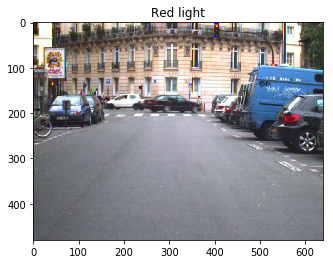

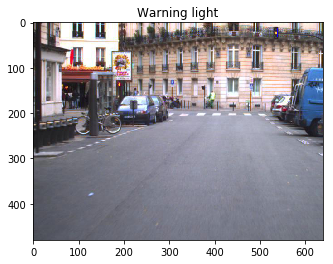

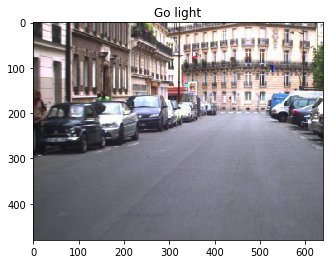

In [31]:
# Import images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

# Make a list of images
image_folder = 'Lara_UrbanSeq1_JPG/Lara3D_UrbanSeq1_JPG'
images = glob.glob('./{}/*.jpg'.format(image_folder))

def retrieve_image_example(type_light, index = 50):
    stop_rows = df[df['subtype']==type_light]
    frame_idx = str(stop_rows['frameindex'].values[index])
    light_pos = np.fromstring(stop_rows['obj_position'].values[index], dtype=int, sep=' ')
    frame_idx = frame_idx.zfill(6) # Pad number with zeros
    stop_image = plt.imread('./{}/frame_{}.jpg'.format(image_folder,frame_idx))

    return cv2.rectangle(stop_image,(light_pos[0],light_pos[1]),(light_pos[2],light_pos[3]),(20,0,255), 1) 


# Plot image with stop light
plt.imshow(retrieve_image_example('stop'))
plt.title('Red light')
plt.show()


# Plot image with warning light
plt.imshow(retrieve_image_example('warning'))
plt.title('Warning light')
plt.show()


# Plot image with go light
plt.imshow(retrieve_image_example('go'))
plt.title('Go light')
plt.show()




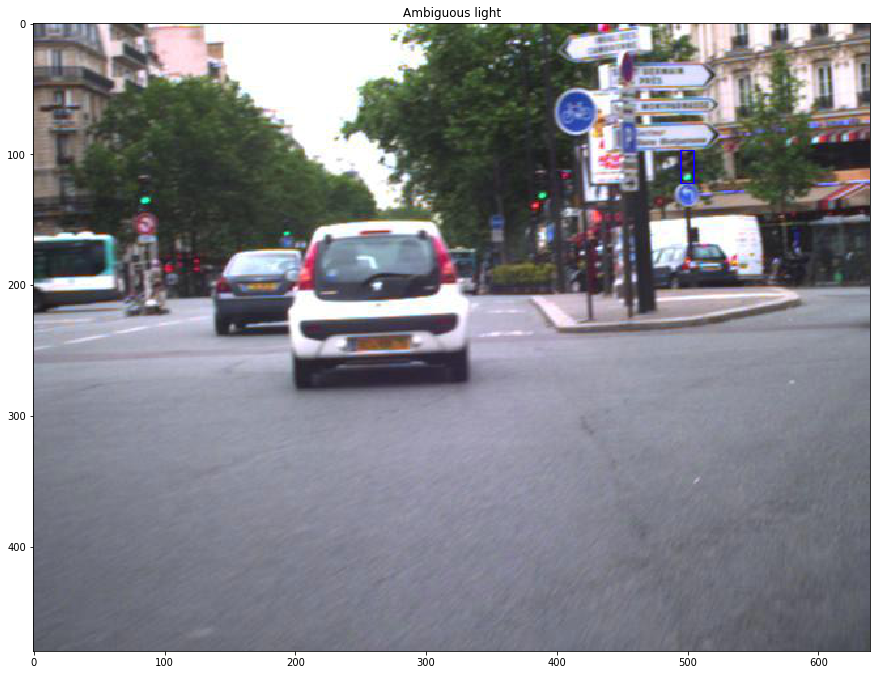

In [34]:
# Plot image with ambiguous light
plt.figure(figsize=(15,15))
plt.imshow(retrieve_image_example('ambiguous', 380))
plt.title('Ambiguous light')
plt.show()


**This last example demonstrates the limitations of this training dataset: Multiple traffic lights with different colors! **


# Model
The original paper uses VGG for implementing the detector.


TODO : Will try experimenting with Xception and MobileNet  
https://keras.io/applications/#usage-examples-for-image-classification-models


In [1]:
# Extract features from an arbitrary intermediate layer with VGG19

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3),pooling=None, include_top=False)


print('Pre-trained model loaded.')


#from keras.utils import plot_model
#plot_model(base_model, to_file='model.png')
base_model.summary()

for layer in base_model.layers:
    layer.trainable = False


Using TensorFlow backend.


Pre-trained model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)  

In [15]:

# Extract pooling layers out of VGG-16


num_classes = 4
num_coordinates = 4 
#Add a classifier and 
from keras.layers import Dense, Conv2D, Conv2DTranspose, Add, Flatten

layer_5_1x1 = Conv2D(num_classes+num_coordinates, 1, padding='same', data_format=None,
               activation='elu')(base_model.get_layer('block5_pool').output)

expand_layer_5 = Conv2DTranspose(num_classes+num_coordinates, 3, strides=(2, 2), padding='same', activation='elu')(layer_5_1x1)

layer_4_1x1 = Conv2D(num_classes+num_coordinates, 1, padding='same', data_format=None,
               activation='elu')(base_model.get_layer('block4_pool').output)

merge_5_and_4 = Add()([expand_layer_5, layer_4_1x1])

expand_layer_4_and_5 = Conv2DTranspose(num_classes+num_coordinates, 3, strides=(2, 2), padding='same', activation='elu')(merge_5_and_4)

layer_3_1x1 = Conv2D(num_classes+num_coordinates, 1, padding='same', data_format=None,
               activation='elu')(base_model.get_layer('block3_pool').output)

merge_out = Add()([expand_layer_4_and_5, layer_3_1x1])

flatten_out = Flatten()(merge_out)

dense_class_out = Dense(num_classes, activation='softmax', name='class_out')(flatten_out)
dense_position_out = Dense(num_coordinates, activation='relu', name='position_out')(flatten_out)


In [16]:
# Build a classifier model to put on top of the convolutional model

model = Model(inputs=base_model.input, outputs=[dense_class_out,dense_position_out])

In [18]:
model.summary()

for i in model.layers:
    print(i.trainable)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [ ]:
# TODO: Batch generator

In [ ]:
model.compile(optimizer='rmsprop',
              loss={'class_out': 'categorical_crossentropy', 'position_out': 'mean_squared_error'},
              loss_weights={'main_output': 1., 'aux_output': 0.5})

# And trained it via:
model.fit(images, {'class_out': labels, 'position_out': positions},
          epochs=50, batch_size=32)